### Prerequisitions: 


#### Install Anaconda to get the same Python environment?
Follow the inscrutions under the following link https://docs.anaconda.com/anaconda/install/ to get Anaconda installed on your machine

#### Run the command "conda env create -f pauls_environment.yml"
In this working directory are some environment yaml files that you can use to easily setup an identical environment as the author of this notebook.

#### How to include more countries?
The following Notebook will work with the ~4k Privacy policies from the file "10_medical_and_fitness.json", which is a scrape from the Playstore of 10 western countries, including the genres MEDICAL and HEALTH & FITNESS

If you want to add other countries please use the scraper by Facundo Olano https://github.com/facundoolano/google-play-scraper. It is written in javascript and therefore not included in this Notebook.

the following example code is a possible configuration to run the scraper. Make sure you use an VPN to set your country to the USA or whatever Playstore you want to scrape from.

---example JS Code---

const util = require('util')

util.inspect.defaultOptions.maxArrayLength = null;

var gplay = require('google-play-scraper');

gplay.list({

    category: gplay.category.MEDICAL,
    
    collection: gplay.collection.TOP_FREE,
    
    lang: 'en',
    
    country: 'us',
    
    fullDetail: true,
    
    num: 50,
    
    throttle: 10
    
})

    .then((result) => console.log(JSON.stringify(result)), console.log);
    
---End of example JS Code---  


In [1]:
import numpy as np
import pandas as pd
from os import path
from wordcloud import WordCloud, ImageColorGenerator
import matplotlib.pyplot as plt
import spacy
import nltk
import re
from nltk.corpus import stopwords
from collections import Counter
import unicodedata
import string
import sys
import pickle
import nltk
import os
from nltk.corpus import webtext
import plotly.express as px
from readability import Readability
import statistics
from decimal import *


INPUT_FILENAME = '10_medical_and_fitness'
INPUT_FILETYPE = 'json'
workdir = os.getcwd()

#### Reading the scraped privacy policies

In [2]:
def readDataFrame(filename, filetype):    
    if (filetype == 'pkl'):
        df = pd.read_pickle(filename+".pkl")
        return df
    if (filetype == 'json'):
        df = pd.read_json(filename+".json")
        return df
    return None

def saveDataFrame(df_to_save, filename, filetype):    
    if (filetype == 'pkl'):
        df_to_save.to_pickle(filename+".pkl")        
    if (filetype == 'json'):
        df_to_save.to_json(filename+".json")        





In [3]:
df = readDataFrame(INPUT_FILENAME, INPUT_FILETYPE)
print(df.shape[0])

3992


In [4]:
counting_df = df.groupby(['hostingLocation']).mean()

##Counting how often each country is represented
helper_df = df['hostingLocation'].value_counts()

for country in counting_df.index:
    counting_df.at[country, "entriesPerCountry"] = helper_df[country]
    
counting_df[["entriesPerCountry"]].head(100) 

entriesPerCountry
hostingLocation                        
Argentina                           1.0
Australia                          84.0
Austria                            20.0
Azerbaijan                          1.0
Bangladesh                          3.0
Belgium                             6.0
Brazil                              6.0
Bulgaria                            9.0
Canada                            115.0
China                              42.0
Czech Republic                      8.0
Denmark                            18.0
Estonia                             1.0
Fiji                                1.0
Finland                             7.0
France                            126.0
Germany                           431.0
Greece                              1.0
Hong Kong                          20.0
Hungary                             9.0
India                              13.0
Indonesia                           6.0
Iran                                2.0
Ireland                           110.0
Israel                              4.0
Italy                              76.0
Japan                             165.0
Kazakhstan                          4.0
Kuwait                              6.0
Latvia                              1.0
Lebanon                             4.0
Luxembourg                          7.0
Malaysia                            1.0
Mongolia                            3.0
Netherlands                       122.0
Oman                                3.0
Pakistan                            3.0
Poland                             15.0
Republic of Korea                   7.0
Romania                             2.0
Russia                             21.0
Saudi Arabia                        6.0
Singapore                          54.0
Slovak Republic                     2.0
Slovenia                            1.0
South Africa                        1.0
Spain                              24.0
Sweden                              4.0
Switzerland                        30.0
Thailand                            3.0
Tunisia                             1.0
Turkey                              9.0
Ukraine                            12.0
United Arab Emirates               22.0
United Kingdom                     84.0
United States                    1798.0
Uzbekistan                          1.0
Vietnam                             2.0

In [5]:
def countVagueTermsRegardingQuantity(phrase_to_check): 
    list_of_vague_terms = ["or more", "about", "several", "approximately", "or less", "some", "a period of",
                           "a list of", "a number of", "few", "many",  "a series of",
                           "around", "almost",  "a set of", "lots of", "a lot of"]
    count = 0
    for term in list_of_vague_terms:
        count += phrase_to_check.count(term)
    return count  
    
def countVagueTermsRegardingTime(phrase_to_check): 
    list_of_vague_terms = ["the end of", "as soon as", "later than", "any time", "from time to time", "often",
                           "sometimes","may sometimes", "occasionally"]
    count = 0
    for term in list_of_vague_terms:
        count += phrase_to_check.count(term)
    return count  
    
def countVagueTermsRegardingDegree(phrase_to_check): 
    list_of_vague_terms = ["necessary", "applicable", "appropriate", "relevant", "sufficient", "suitable",
                           "effective", "adequate", "good", "acceptable", "substantial", "significant",
                           "reasonable",  "considerable"]
    count = 0
    for term in list_of_vague_terms:
        count += phrase_to_check.count(term)
    return count  
    
def countVagueTermsRegardingCategory(phrase_to_check): 
    list_of_vague_terms = ["such a measure", "such measure",
                           "such a case", "such case",
                           "such information",
                           "such a product", "such product",
                           "such a decision", "such decision",
                           "such a notification", "such notification",
                           "such a person", "such person",
                           "such a time", "such time",
                           "such a provision", "such provision",
                           "such a substance", "such substance",
                           "such a material", "such material",
                           "such data"]
    count = 0
    for term in list_of_vague_terms:
        count += phrase_to_check.count(term)  
    return count

In [6]:
# Lemmatizing like https://simonhessner.de/lemmatize-whole-sentences-with-python-and-nltks-wordnetlemmatizer/
import nltk
import textstat
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
from nltk.tokenize import word_tokenize 
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.corpus import words

lemmatizer = WordNetLemmatizer()

def nltk2wn_tag(nltk_tag):    
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:                    
        return None
    
def lemmatize_sentences(sentence):
    
    nltk_tagged = nltk.pos_tag(nltk.word_tokenize(sentence))    
    wn_tagged = map(lambda x: (x[0], nltk2wn_tag(x[1])), nltk_tagged)
    res_words = []
    for word, tag in wn_tagged:
        if tag is not None and wordnet.synsets(word):
            res_words.append(lemmatizer.lemmatize(word, tag))
    return " ".join(res_words)


def lemmatizePrivacyPolicy(policy_text): 
    if isinstance(policy_text, str):
        # Punctuation removal to reduce the noise in the dataset
        #     r’[^\w\s]’: 
        # \w : Matches Unicode word characters
        # \s : Matches Unicode whitespace characters
        # ^: all the characters that are not in the set will be matched
        policy_text = re.sub(r'[^\w\s]','',policy_text)
        # Removing multiple whitespaces in the text
        policy_text = re.sub(' +', ' ', policy_text).strip()
        policy_text = lemmatize_sentences(policy_text)        
    else: 
        return None 
    return policy_text

def count_words(lemmatized_input):
    if isinstance(lemmatized_input, str):
        count = textstat.lexicon_count(lemmatized_input, removepunct=True)
        if count > 50:
            return count
    else:
        return None

    
    
from readability import Readability
    
def get_SMOG_Grade(r_input):
    try:
        return r_input.smog().grade_level
    except:
        return None 
    
def get_FK_Grade(r_input):
    try:
        return r_input.flesch_kincaid().grade_level
    except:
        return None
    
def get_DC_Grade(r_input):
    try:
        return r_input.dale_chall().grade_levels
    except:
        return None 
    
def get_ARI_Grade(r_input):
    try:
        return r_input.ari().grade_levels
    except:
        return None
    
def get_CL_Grade(r_input):
    try:
        return r_input.coleman_liau().grade_level
    except:
        return None 
    
def get_GF_Grade(r_input):
    try:
        return r_input.gunning_fog().grade_level
    except:
        return None     
    

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\lepawi\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\lepawi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\lepawi\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [7]:
def combineCollocation(collocation): 
    joinedCollocation = " ".join(word for word in collocation)
    return  joinedCollocation

    
def isVagueTermRegardingQuantity(phrase_to_check): 
    list_of_vague_terms = ["or more", "about", "several", "approximately", "or less", "some", "period of",
                           "list of", "a list of", "a number of", "few", "many",  "series of",
                           "around", "almost",  "set of", "lots of", "lot of"]
    for term in list_of_vague_terms:
        if term in phrase_to_check:
            return True
    else:                    
        return False
    
def isVagueTermRegardingTime(phrase_to_check): 
    list_of_vague_terms = ["the end of", "as soon as", "later than", "any time", "from time to time", "often",
                           "sometimes","may sometimes", "occasionally"]
    for term in list_of_vague_terms:
        if term in phrase_to_check:
            return True
    else:                    
        return False  
    
def isVagueTermRegardingDegree(phrase_to_check): 
    list_of_vague_terms = ["necessary", "applicable", "appropriate", "relevant", "sufficient", "suitable",
                           "effective", "adequate", "good", "acceptable", "substantial", "significant",
                           "reasonable",  "considerable"]
    for term in list_of_vague_terms:
        if term in phrase_to_check:
            return True
    else:                    
        return False 
    
def isVagueTermRegardingCategory(phrase_to_check): 
    list_of_vague_terms = ["such measures", "such measure",
                           "such cases", "such case",
                           "such information",
                           "such products", "such product",
                           "such decisions", "such decision",
                           "such notifications", "such notification",
                           "such persons", "such person",
                           "such times", "such time",
                           "such provisions", "such provision",
                           "such substances", "such substance",
                           "such materials", "such material",
                           "such data"]
    for term in list_of_vague_terms:
        if term in phrase_to_check:
            return True
    else:                    
        return False     
    
def isVagueCollocation(collocation_to_check): 
    combinedColl = combineCollocation(collocation_to_check)
    if isVagueTermRegardingQuantity(combinedColl):
        return True
    if isVagueTermRegardingTime(combinedColl):
        return True    
    if isVagueTermRegardingDegree(combinedColl):
        return True
    if isVagueTermRegardingCategory(combinedColl):
        return True    
    else:                    
        return False 
    
    
def containsInterestingWords(collocation_to_check, word_list): 
    combinedColl = combineCollocation(collocation_to_check)
    for word in word_list:
        if word in collocation_to_check:
            return True
    else:                    
        return False
    
def isNativelyEnglishSpeakingCountry(country_to_check): 
    list_of_native_english_countries = ["United States", "United Kingdom", "Ireland",
                                        "Canada", "Australia", "New Zealand", "Malta"] #TODO extend if more countries occur
    if country_to_check in list_of_native_english_countries:
        return True
    else:                    
        return False
    
def groupByNumberOfInstallments(number_of_installments): 
    
    if number_of_installments > 5000000:
        return "Very High >5M"
    if number_of_installments > 1000000:
        return "High >1M"   
    if number_of_installments > 250000:
        return "Medium >250k"
    if number_of_installments > 50000:
        return "Low >50k"  
    else:                    
        return "Very Low <50k"     
    
def isShortPrivacyPolicy(number_of_sentences): 
    
    if number_of_sentences >= 30:
        return False
    else:                    
        return True  
    
    
def get_ranked_dataframe(grouping_var, ranking_var):    
    group_series = df[grouping_var]
    rank_series = df[ranking_var].rank(ascending=True)
    ranked_dataframe = group_series.to_frame().join(rank_series)
    ranked_dataframe = ranked_dataframe.groupby([grouping_var]).mean()
    return ranked_dataframe

def get_mean_rank(ranked_dataframe, ranking_var, grouping_var_value):
    if grouping_var_value == "Country":
        return None
    return ranked_dataframe.at[grouping_var_value, ranking_var].round(1)    

In [8]:
df[["appId", "maxInstalls", "hostingLocation","privacyPolicyLanguage","privacyPolicyText", "privacyPolicy"]].head()

appId  maxInstalls hostingLocation  \
0    com.lbrc.PeriodCalendar     13520110   United States   
1  fr.gouv.android.stopcovid     11197757          France   
2           com.szyk.myheart     11038109          Canada   
3     ru.mobiledimension.kbr      8925302          Russia   
4        com.smsrobot.period      8584794   United States   

  privacyPolicyLanguage                                  privacyPolicyText  \
0                  None                                               None   
1                    fr  TousAntiCovid - données personnelles\n\n\n\n\n...   
2                    en  Szymon Klimaszewski - Privacy PolicySearch thi...   
3                    ru  Календарь беременности\n\n\n\n\n\n\n\n\n\n\n\n...   
4                    en  Lilly Tracker Privacy Policy\n\n\n\n\n\n\n\n\n...   

                                       privacyPolicy  
0  https://simpleinnovation.us/simpleinnovation/p...  
1  https://bonjour.tousanticovid.gouv.fr/privacy....  
2     http://www.klimaszewski.mobi/privacy_policy_bp  
3             https://pregnancytracker.app/politika/  
4  http://www.smsrobot.com/privacypolicy_period.html

In [9]:
print(df.shape[0])

3992


In [10]:
counting_df = df.groupby(['hostingLocation']).mean()

##Counting how often each country is represented
helper_df = df['hostingLocation'].value_counts()

for country in counting_df.index:
    counting_df.at[country, "entriesPerCountry"] = helper_df[country]
    
counting_df[["entriesPerCountry"]].head(100) 

entriesPerCountry
hostingLocation                        
Argentina                           1.0
Australia                          84.0
Austria                            20.0
Azerbaijan                          1.0
Bangladesh                          3.0
Belgium                             6.0
Brazil                              6.0
Bulgaria                            9.0
Canada                            115.0
China                              42.0
Czech Republic                      8.0
Denmark                            18.0
Estonia                             1.0
Fiji                                1.0
Finland                             7.0
France                            126.0
Germany                           431.0
Greece                              1.0
Hong Kong                          20.0
Hungary                             9.0
India                              13.0
Indonesia                           6.0
Iran                                2.0
Ireland                           110.0
Israel                              4.0
Italy                              76.0
Japan                             165.0
Kazakhstan                          4.0
Kuwait                              6.0
Latvia                              1.0
Lebanon                             4.0
Luxembourg                          7.0
Malaysia                            1.0
Mongolia                            3.0
Netherlands                       122.0
Oman                                3.0
Pakistan                            3.0
Poland                             15.0
Republic of Korea                   7.0
Romania                             2.0
Russia                             21.0
Saudi Arabia                        6.0
Singapore                          54.0
Slovak Republic                     2.0
Slovenia                            1.0
South Africa                        1.0
Spain                              24.0
Sweden                              4.0
Switzerland                        30.0
Thailand                            3.0
Tunisia                             1.0
Turkey                              9.0
Ukraine                            12.0
United Arab Emirates               22.0
United Kingdom                     84.0
United States                    1798.0
Uzbekistan                          1.0
Vietnam                             2.0

In [11]:
##This is for manually deleting policy texts that we couldnt even manually scrape,
manual_deletions_file = open('manual_deletions/manual_deletions.txt', 'r')

for appId in manual_deletions_file.readlines():
    df = df[df.appId != appId.strip()]
    
df.reset_index(inplace = True, drop = True)
print(df.shape[0])

3911


In [12]:
##This is for manually replacing policy texts that we had to manually scrape
replacement_directory = "manual_replacements"

for filename in os.listdir(replacement_directory):
    appId = filename[:-4]
    try:
        indextoedit = df.index[df['appId']==(appId)][0]
    except:
        continue
    
    with open(replacement_directory+"/"+filename, 'rb') as f:
        bytetxt = f.read()    
    replacingPolicy = bytetxt.decode("utf-8")
    replacingPolicy = replacingPolicy.replace('\\r', '')    
    replacingPolicy = replacingPolicy.replace('\\n', '')
    replacingPolicy = replacingPolicy.replace('\\t', '')
    replacingPolicy = replacingPolicy.replace('\n', '')
    replacingPolicy = replacingPolicy.replace('\r', '')
    replacingPolicy = replacingPolicy.replace('\t', '')
    df.at[indextoedit, "privacyPolicyText"] = replacingPolicy

In [13]:
dups = df.pivot_table(columns=['appId'], aggfunc='size')
print (dups)

appId
ab.damumed                                                   1
abnehm.app.low.carb                                          1
absworkout.bellyfatworkout.waistworkout.abdominalworkout     1
activity.francesco.perini.it.ulssveneto                      1
adam.exercisedictionary                                      2
                                                            ..
xri.pt                                                       1
yogaworkout.dailyyoga.go.weightloss.loseweight              10
yogaworkouts.loseweight.dailyyoga                            3
za.gov.health.covidconnect                                   1
zar.com.zarpat                                               1
Length: 1992, dtype: int64


In [14]:
df = df.drop_duplicates(subset=['appId'], keep='first')
df.reset_index(inplace = True, drop = True)
print(df.shape[0])

1992


In [15]:
# Dropping all non english privacy policies
df = df[df.privacyPolicyLanguage == 'en']
df.reset_index(inplace = True, drop = True)
print(df.shape[0])

1035


In [16]:
# Dropping all Policies without hosting Location and without GenreID
df = df.dropna(subset=['hostingLocation'])
df.reset_index(inplace = True, drop = True)
df = df.dropna(subset=['genreId'])
df.reset_index(inplace = True, drop = True)
print(df.shape[0])

1025


In [17]:
counting_df = df.groupby(['hostingLocation']).mean()

##Counting how often each country is represented
helper_df = df['hostingLocation'].value_counts()

for country in counting_df.index:
    counting_df.at[country, "entriesPerCountry"] = helper_df[country]
    
counting_df[["entriesPerCountry"]].head(100)    

entriesPerCountry
hostingLocation                        
Australia                          71.0
Austria                             2.0
Bangladesh                          1.0
Belgium                             3.0
Brazil                              1.0
Bulgaria                            1.0
Canada                             54.0
China                               7.0
Czech Republic                      3.0
Denmark                             1.0
Estonia                             1.0
Finland                             3.0
France                             25.0
Germany                           113.0
Greece                              1.0
Hong Kong                           5.0
India                               8.0
Indonesia                           2.0
Ireland                            49.0
Italy                               9.0
Japan                              19.0
Kazakhstan                          1.0
Kuwait                              2.0
Latvia                              1.0
Malaysia                            1.0
Netherlands                        39.0
Pakistan                            1.0
Poland                              2.0
Republic of Korea                   4.0
Russia                              4.0
Singapore                          21.0
Slovak Republic                     1.0
South Africa                        1.0
Spain                               3.0
Sweden                              3.0
Switzerland                         4.0
Ukraine                             4.0
United Arab Emirates                3.0
United Kingdom                     52.0
United States                     499.0

In [18]:
df.head()

IAPRange  adSupported androidVersion androidVersionText  \
0  $2.09 - $28.99 per item         True            4.2         4.2 and up   
1           $3.39 per item         True            4.1         4.1 and up   
2                     None        False            4.3         4.3 and up   
3  $0.99 - $50.00 per item        False            4.4         4.4 and up   
4                     None        False            5.0         5.0 and up   

                                  appId contentRating currency  \
0                      com.szyk.myheart  Rated for 3+      AUD   
1                   com.smsrobot.period  Rated for 3+      AUD   
2                           com.ada.app  Rated for 3+      AUD   
3  com.AnatomyLearning.Anatomy3DViewer3  Rated for 3+      AUD   
4                   com.kemenkes.inahac  Rated for 3+      AUD   

                                         description  \
0  Control your blood pressure with multiple buil...   
1  Period and Ovulation Tracker Lilly\r\n\r\nLill...   
2  Ada helps you and your loved ones check sympto...   
3  A true and totally 3D app for studying human a...   
4  Mandatory application for any travelers from e...   

                         developer  \
0              Klimaszewski Szymon   
1                     SMSROBOT LTD   
2                       Ada Health   
3              AnatomyLearning LLC   
4  Health Quarantine MoH Indonesia   

                                    developerAddress  ...  \
0  Szymon Klimaszewski\nWita Stwosza 16\n50-148 W...  ...   
1  THE BLACK CHURCH\nST. MARY’S PLACE\nDUBLIN 7\n...  ...   
2  Ada Health GmbH\nKarl-Liebknecht-Straße 1\n101...  ...   
3          Calle Cuenca 23 Puerta 5\n46007\nValencia  ...   
4  Jl. HR Rasuna Said Kav. X-5 No. 4-9\nJakarta S...  ...   

                                 title        updated  \
0                       Blood Pressure  1622099088000   
1         Period and Ovulation Tracker  1603230505000   
2              Ada – check your health  1621843885000   
3  Anatomy Learning - 3D Anatomy Atlas  1616517794000   
4                       eHAC Indonesia  1607328678000   

                                                 url       version  \
0  https://play.google.com/store/apps/details?id=...  Google-6.5.4   
1  https://play.google.com/store/apps/details?id=...           6.5   
2  https://play.google.com/store/apps/details?id=...        3.12.0   
3  https://play.google.com/store/apps/details?id=...       2.1.322   
4  https://play.google.com/store/apps/details?id=...           4.0   

                                               video  \
0  https://www.youtube.com/embed/lHjQNtiXKso?ps=p...   
1                                               None   
2  https://www.youtube.com/embed/tuhKvY-X8Zs?ps=p...   
3  https://www.youtube.com/embed/d5Ewm0C3vVQ?ps=p...   
4                                               None   

                                         videoImage contentRatingDescription  \
0  https://i.ytimg.com/vi/lHjQNtiXKso/hqdefault.jpg                     None   
1                                              None                     None   
2  https://i.ytimg.com/vi/tuhKvY-X8Zs/hqdefault.jpg                     None   
3  https://i.ytimg.com/vi/d5Ewm0C3vVQ/hqdefault.jpg                     None   
4                                              None                     None   

  fromPlaystore familyGenre familyGenreId  
0          None        None          None  
1          None        None          None  
2          None        None          None  
3          None        None          None  
4          None        None          None  

[5 rows x 46 columns]

In [19]:
saveDataFrame(df,INPUT_FILENAME+'_only_en', INPUT_FILETYPE)

### BREAKPOINT: Loading Dataframe with all non english policies removed

In [20]:
df = readDataFrame(INPUT_FILENAME+'_only_en', INPUT_FILETYPE)
print(df.shape[0])

1025


In [21]:
# Counting Vague Terms in all Privacy Policies of the Dataframe
for i in df.index:
    
    #df.at[i, "MVLocationGenre"] = df.at[i, "hostingLocation"] +" "+ df.at[i, "genreId"]
    
    if df.at[i, "genreId"] == "MEDICAL":
        df.at[i, "MVLocationGenreIcon"] = df.at[i, "hostingLocation"] +" ⚕️" 

        df.at[i, "MVLocationGenre"] = df.at[i, "hostingLocation"] +" MED"
        df.at[i, "genreId"] = "MED"
        
    if df.at[i, "genreId"] == "HEALTH_AND_FITNESS":
        df.at[i, "MVLocationGenreIcon"] = df.at[i, "hostingLocation"] +" 🏋️‍♂️"
        df.at[i, "MVLocationGenre"] = df.at[i, "hostingLocation"] +" H&F"
        df.at[i, "genreId"] = "H&F"
        
    df.at[i, "SMOGIndex"] = textstat.smog_index(df.at[i, "privacyPolicyText"])
    df.at[i, "FleschReadingEase"] = textstat.flesch_reading_ease(df.at[i, "privacyPolicyText"])
    df.at[i, "FleschKincaidGrade"] = textstat.flesch_kincaid_grade(df.at[i, "privacyPolicyText"])
    df.at[i, "ColemanLiau"] = textstat.coleman_liau_index(df.at[i, "privacyPolicyText"])
    df.at[i, "AutomatedReadabilityIndex"] = textstat.automated_readability_index(df.at[i, "privacyPolicyText"])
    df.at[i, "GunningFog"] = textstat.gunning_fog(df.at[i, "privacyPolicyText"])
    df.at[i, "DaleChall"] = textstat.dale_chall_readability_score(df.at[i, "privacyPolicyText"])
    
    df.at[i, "SentenceCount"] = textstat.sentence_count(df.at[i, "privacyPolicyText"])
    df.at[i, "isShortPolicy"] = isShortPrivacyPolicy(df.at[i, "SentenceCount"])
    df.at[i, "wordCount"] = count_words(df.at[i, "privacyPolicyText"])
      
    #df.at[i, "privacyPolicyText"] = df.at[i, "privacyPolicyText"].translate(str.maketrans('', '', string.punctuation))
    df.at[i, "vagueQuantityCounter"] = countVagueTermsRegardingQuantity(df.at[i, "privacyPolicyText"])
    df.at[i, "vagueTimeCounter"] = countVagueTermsRegardingTime(df.at[i, "privacyPolicyText"])
    df.at[i, "vagueDegreeCounter"] = countVagueTermsRegardingDegree(df.at[i, "privacyPolicyText"])
    df.at[i, "vagueCategoryCounter"] = countVagueTermsRegardingCategory(df.at[i, "privacyPolicyText"])
    df.at[i, "vagueTotalCounter"] = df.at[i, "vagueCategoryCounter"] + df.at[i, "vagueDegreeCounter"] + df.at[i, "vagueTimeCounter"] + df.at[i, "vagueQuantityCounter"]   
    df.at[i, "vagueTimePercentage"] = "{:.4f}".format(df.at[i, "vagueTimeCounter"] / df.at[i, "wordCount"])
    df.at[i, "vagueDegreePercentage"] = "{:.4f}".format(df.at[i, "vagueDegreeCounter"] / df.at[i, "wordCount"])
    df.at[i, "vagueCategoryPercentage"] = "{:.4f}".format(df.at[i, "vagueCategoryCounter"] / df.at[i, "wordCount"])
    df.at[i, "vagueQuantityPercentage"] = "{:.4f}".format(df.at[i, "vagueQuantityCounter"] / df.at[i, "wordCount"])
    df.at[i, "vagueTotalPercentage"] = "{:.4f}".format(df.at[i, "vagueTotalCounter"] / df.at[i, "wordCount"])
 
    #checkIfNative
    df.at[i, "isNativelyEnglish"] = isNativelyEnglishSpeakingCountry(df.at[i, "hostingLocation"])
    df.at[i, "SyllableCount"] = textstat.syllable_count(df.at[i, "privacyPolicyText"])

    #reading speed calculation
    df.at[i, "averageMinutesToReadNative"] = df.at[i, "wordCount"] / 238
    df.at[i, "averageMinutesToReadSkilled"] = df.at[i, "wordCount"] / 300
    df.at[i, "averageMinutesToReadNonNative"] = df.at[i, "wordCount"] / 139
      

    
    index_5items = [df.at[i, "SMOGIndex"], df.at[i, "FleschKincaidGrade"], 
             df.at[i, "GunningFog"], df.at[i, "ColemanLiau"], df.at[i, "AutomatedReadabilityIndex"]]

    df.at[i, "meanReadability"] = statistics.mean(index_5items)
    
    df.at[i, "medianReadability"] = statistics.median(index_5items)
    
    index_4items = [df.at[i, "SMOGIndex"], df.at[i, "FleschKincaidGrade"], 
             df.at[i, "GunningFog"], df.at[i, "AutomatedReadabilityIndex"]]

    df.at[i, "meanReadabilityNoCL"] = statistics.mean(index_4items)
    df.at[i, "amountOfInstallsGrouped"] = groupByNumberOfInstallments(df.at[i, "maxInstalls"])
    
    # Using Ln to fight potential skewed data
    #df.at[i, "LOGaverageMinutesToReadNative"] = np.log(df.at[i, "averageMinutesToReadNative"]) 
    #df.at[i, "LOGmeanReadability"] = np.log(df.at[i, "meanReadability"])
    #df.at[i, "LOGvagueTotalPercentage"] = np.log(df.at[i, "vagueTotalPercentage"])

In [22]:
df[["appId", "maxInstalls", "hostingLocation", "MVLocationGenre","privacyPolicyLanguage","privacyPolicyText", "privacyPolicy", "vagueTotalCounter", "wordCount", "SMOGIndex"]].head()

appId  maxInstalls hostingLocation  \
0                      com.szyk.myheart     11038109          Canada   
1                   com.smsrobot.period      8584794   United States   
2                           com.ada.app      7913573         Germany   
3  com.AnatomyLearning.Anatomy3DViewer3      6668766   United States   
4                   com.kemenkes.inahac      5894532       Indonesia   

     MVLocationGenre privacyPolicyLanguage  \
0         Canada MED                    en   
1  United States MED                    en   
2        Germany MED                    en   
3  United States MED                    en   
4      Indonesia MED                    en   

                                   privacyPolicyText  \
0  Privacy PolicyThe app collects only data, whic...   
1  Lilly Tracker Privacy Policy\n\n\n\n\n\n\n\n\n...   
2      Download Ada    Meet Ada        About us  ...   
3  Not Acceptable!Not Acceptable!An appropriate r...   
4  DIT P2P| Kementerian Kesehatan RI\n\n\n\n\n\n\...   

                                       privacyPolicy  vagueTotalCounter  \
0     http://www.klimaszewski.mobi/privacy_policy_bp                1.0   
1  http://www.smsrobot.com/privacypolicy_period.html               13.0   
2                     https://ada.com/privacy-policy              135.0   
3        http://www.anatomylearning.com/ppolicy.html                1.0   
4                https://inahac.kemkes.go.id/privacy                4.0   

   wordCount  SMOGIndex  
0      133.0       17.1  
1     1623.0       15.7  
2     9558.0       22.2  
3        NaN        0.0  
4      723.0       20.3

In [23]:
print(df.shape[0])

1025


In [24]:
# Dropping all too short privacy policies
df = df[df.SMOGIndex > 0]
df.reset_index(inplace = True, drop = True)
print(df.shape[0])

852


In [25]:
#categories_to_filter = ['averageMinutesToReadNative', 'SMOGIndex', 'vagueTotalPercentage']

#for category in categories_to_filter:
#    # Dropping outliers - usually scraped texts that are probably no privacy policy but rather FAQ etc
#    Q1 = df[category].quantile(0.25)
#    Q3 = df[category].quantile(0.75)
#    IQR = Q3 - Q1    #IQR is interquartile range.     
#    filtered_indexes = ((df[category] >= Q1 - 1.5 * IQR) & (df[category] <= Q3 + 1.5 *IQR))
#    print(filtered_indexes)
#    df = df.loc[filtered_indexes]
#    print("Got " + str(df.shape[0]) + "Entries after removing outliers for category " + str(category))
#    df.reset_index(inplace = True, drop = True)

In [26]:
saveDataFrame(df,INPUT_FILENAME+'_only_en_with_textstats', INPUT_FILETYPE)
print(df.shape[0])

852


### BREAKPOINT: Loading Dataframe with Readability and Vagueness already calculated

In [27]:
df = readDataFrame(INPUT_FILENAME+'_only_en_with_textstats', INPUT_FILETYPE)
print(df.shape[0])

852


In [28]:
df[["SMOGIndex", 
    "FleschKincaidGrade",
    "GunningFog",
    "DaleChall",
    "ColemanLiau",
    "AutomatedReadabilityIndex",
    "SyllableCount", "SentenceCount", "wordCount"]].head(20)

SMOGIndex  FleschKincaidGrade  GunningFog  DaleChall  ColemanLiau  \
0        17.1                20.6       22.23       9.63        10.58   
1        15.7                15.2       15.35       7.65        14.92   
2        22.2                27.3       25.15       7.78        13.01   
3        20.3                23.3       22.82       8.82        13.77   
4        14.2                13.6       12.45       7.87        12.59   
5        18.2                18.1       16.00       7.51        14.98   
6        17.4                17.4       14.75       7.02        16.72   
7        21.5                23.3       19.57       6.94        15.45   
8        15.5                13.8       14.22       8.11        12.89   
9        17.0                16.6       17.23       8.02        12.83   
10       16.4                30.5       17.25       7.86        14.86   
11       17.5                17.7       16.49       7.38        13.94   
12       15.3                15.0       15.22       7.93        12.78   
13       16.6                16.2       15.17       7.42        14.23   
14       20.8                24.8       22.56       8.14        14.52   
15       16.2                15.9       15.84       7.45        14.28   
16       17.4                16.1       15.53       8.02        17.18   
17       17.1                17.0       15.22       8.25        17.99   
18       22.6                24.8       23.13       8.64        19.63   
19       13.4                11.4       12.27       7.12        10.22   

    AutomatedReadabilityIndex  SyllableCount  SentenceCount  wordCount  
0                        22.9            208              3        133  
1                        20.4           2588             53       1623  
2                        32.6          16469            163       9558  
3                        27.8           1264             15        723  
4                        13.8           1304             36        736  
5                        21.0           3746             66       2114  
6                        21.7           9533            177       5341  
7                        27.9          20705            248      11231  
8                        15.4           1507             38        909  
9                        20.1           1389             25        849  
10                       23.0           3114             31       1133  
11                       21.3           7168            126       4279  
12                       18.0           1187             25        748  
13                       19.5           5360            107       3219  
14                       28.8           5951             68       3334  
15                       20.5           4737             89       2872  
16                       21.5           1487             29        865  
17                       21.1           1842             38        995  
18                       33.0           7216             83       4064  
19                       13.2           1233             34        811

In [29]:
print(df.shape[0])

852


In [30]:
multivalue_avg_df = df.groupby(['hostingLocation', 'genreId']).mean()

##Counting how often each country is represented
country_df = df['hostingLocation'].value_counts()
##Counting how often each country is represented
genre_df = df['genreId'].value_counts()
country_genre_df = df['MVLocationGenre'].value_counts()

In [31]:
country_genre_df.head(200)

United States MED           217
United States H&F           200
Germany MED                  70
Australia MED                40
Canada MED                   34
Germany H&F                  29
United Kingdom MED           26
Ireland H&F                  25
Australia H&F                20
Ireland MED                  20
Netherlands H&F              16
United Kingdom H&F           16
Netherlands MED              14
Canada H&F                   12
Japan MED                    10
Singapore MED                10
France H&F                   10
France MED                    9
Japan H&F                     6
China H&F                     6
Singapore H&F                 5
Russia H&F                    4
Italy MED                     3
Hong Kong H&F                 3
Ukraine H&F                   3
India MED                     3
India H&F                     2
United Arab Emirates MED      2
Finland MED                   2
Spain MED                     2
Belgium MED                   2
Poland M

In [32]:
multivalue_avg_df = df.groupby(['hostingLocation', 'genreId']).mean()



for (country,genre) in multivalue_avg_df.index:    
    multivalue_avg_df.at[(country,genre), "entriesPerCountryAndGenre"] = country_genre_df[country+" "+genre]
    multivalue_avg_df.at[(country,genre), "entriesPerCountry"] = country_df[country]
    
multivalue_avg_df[["entriesPerCountryAndGenre", "entriesPerCountry",
                   "vagueTimePercentage", "vagueDegreePercentage", 
                   "vagueCategoryPercentage", "vagueQuantityPercentage",
                   "vagueTotalPercentage", "vagueTotalCounter",
                   "wordCount", "SMOGIndex"]].head(20)   

entriesPerCountryAndGenre  entriesPerCountry  \
hostingLocation genreId                                                 
Australia       H&F                           20.0               60.0   
                MED                           40.0               60.0   
Austria         H&F                            2.0                2.0   
Bangladesh      MED                            1.0                1.0   
Belgium         H&F                            1.0                3.0   
                MED                            2.0                3.0   
Bulgaria        H&F                            1.0                1.0   
Canada          H&F                           12.0               46.0   
                MED                           34.0               46.0   
China           H&F                            6.0                6.0   
Estonia         MED                            1.0                1.0   
Finland         H&F                            1.0                3.0   
                MED                            2.0                3.0   
France          H&F                           10.0               19.0   
                MED                            9.0               19.0   
Germany         H&F                           29.0               99.0   
                MED                           70.0               99.0   
Hong Kong       H&F                            3.0                5.0   
                MED                            2.0                5.0   
India           H&F                            2.0                5.0   

                         vagueTimePercentage  vagueDegreePercentage  \
hostingLocation genreId                                               
Australia       H&F                 0.001045               0.003700   
                MED                 0.001550               0.005325   
Austria         H&F                 0.001100               0.003700   
Bangladesh      MED                 0.000000               0.008200   
Belgium         H&F                 0.000000               0.000000   
                MED                 0.002000               0.002000   
Bulgaria        H&F                 0.002900               0.004300   
Canada          H&F                 0.000800               0.002633   
                MED                 0.001065               0.004462   
China           H&F                 0.001833               0.004450   
Estonia         MED                 0.001300               0.003900   
Finland         H&F                 0.000900               0.002400   
                MED                 0.003700               0.006100   
France          H&F                 0.001590               0.003260   
                MED                 0.001922               0.003378   
Germany         H&F                 0.001466               0.003714   
                MED                 0.001324               0.004716   
Hong Kong       H&F                 0.001867               0.003900   
                MED                 0.000800               0.007550   
India           H&F                 0.001200               0.002750   

                         vagueCategoryPercentage  vagueQuantityPercentage  \
hostingLocation genreId                                                     
Australia       H&F                     0.000230                 0.007270   
                MED                     0.000218                 0.007450   
Austria         H&F                     0.000500                 0.003900   
Bangladesh      MED                     0.000000                 0.012300   
Belgium         H&F                     0.000000                 0.003900   
                MED                     0.000000                 0.001000   
Bulgaria        H&F                     0.001400                 0.000700   
Canada          H&F                     0.000108                 0.004917   
                MED                     0.000356                 0.004776   
China   

In [33]:
#Since Plotly doesn't like to draw diagrams with multiple "keys" like the hosting Location and genreId, 
#we now create a "fake" Multivalue Primary Key / Materialized View by writing both columns into one.

fake_mv_avg_df = df.groupby(['MVLocationGenre']).mean()
##Counting how often each country is represented

for locationGenre in fake_mv_avg_df.index:
    fake_mv_avg_df.at[locationGenre, "entriesPerCountryAndGenre"] = country_genre_df[locationGenre]
    
    
fake_mv_avg_df[["entriesPerCountryAndGenre",
                   "vagueTimePercentage", "vagueDegreePercentage", 
                   "vagueCategoryPercentage", "vagueQuantityPercentage",
                   "vagueTotalPercentage", "vagueTotalCounter",
                   "wordCount", "SMOGIndex"]].head(20)    

entriesPerCountryAndGenre  vagueTimePercentage  \
MVLocationGenre                                                   
Australia H&F                         20.0             0.001045   
Australia MED                         40.0             0.001550   
Austria H&F                            2.0             0.001100   
Bangladesh MED                         1.0             0.000000   
Belgium H&F                            1.0             0.000000   
Belgium MED                            2.0             0.002000   
Bulgaria H&F                           1.0             0.002900   
Canada H&F                            12.0             0.000800   
Canada MED                            34.0             0.001065   
China H&F                              6.0             0.001833   
Estonia MED                            1.0             0.001300   
Finland H&F                            1.0             0.000900   
Finland MED                            2.0             0.003700   
France H&F                            10.0             0.001590   
France MED                             9.0             0.001922   
Germany H&F                           29.0             0.001466   
Germany MED                           70.0             0.001324   
Hong Kong H&F                          3.0             0.001867   
Hong Kong MED                          2.0             0.000800   
India H&F                              2.0             0.001200   

                 vagueDegreePercentage  vagueCategoryPercentage  \
MVLocationGenre                                                   
Australia H&F                 0.003700                 0.000230   
Australia MED                 0.005325                 0.000218   
Austria H&F                   0.003700                 0.000500   
Bangladesh MED                0.008200                 0.000000   
Belgium H&F                   0.000000                 0.000000   
Belgium MED                   0.002000                 0.000000   
Bulgaria H&F                  0.004300                 0.001400   
Canada H&F                    0.002633                 0.000108   
Canada MED                    0.004462                 0.000356   
China H&F                     0.004450                 0.000667   
Estonia MED                   0.003900                 0.000000   
Finland H&F                   0.002400                 0.000100   
Finland MED                   0.006100                 0.000000   
France H&F                    0.003260                 0.000190   
France MED                    0.003378                 0.000533   
Germany H&F                   0.003714                 0.000407   
Germany MED                   0.004716                 0.000440   
Hong Kong H&F                 0.003900                 0.000000   
Hong Kong MED                 0.007550                 0.000000   
India H&F                     0.002750                 0.002250   

                 vagueQuantityPercentage  vagueTotalPercentage  \
MVLocationGenre                                                  
Australia H&F                   0.007270              0.012250   
Australia MED                   0.007450              0.014527   
Austria H&F                     0.003900              0.009200   
Bangladesh MED                  0.012300              0.020500   
Belgium H&F                     0.003900              0.003900   
Belgium MED                     0.001000              0.004950   
Bulgaria H&F                    0.000700              0.009300   
Canada H&F                      0.004917              0.008483   
Canada MED                      0.004776              0.010668   
China H&F                       0.003633              0.010567   
Estonia MED                     0.002600              0.007800   
Finland H&F                     0.006300              0.009700   
Finland MED                     0.002500              0.012300   
France H&F                      0.004540              0.009620   
France MED 

In [34]:
# ToDo: add all countries with low amount of entries to a "other" category.
fake_mv_avg_df=fake_mv_avg_df.drop(fake_mv_avg_df[fake_mv_avg_df.entriesPerCountryAndGenre < 15].index)

In [35]:
multivalue_avg_df=multivalue_avg_df.drop(multivalue_avg_df[multivalue_avg_df.entriesPerCountryAndGenre < 15].index)

In [36]:
multivalue_avg_df[["entriesPerCountryAndGenre", "entriesPerCountry",
                   "vagueTimePercentage", "vagueDegreePercentage", 
                   "vagueCategoryPercentage", "vagueQuantityPercentage",
                   "vagueTotalPercentage", "vagueTotalCounter",
                   "wordCount", "SMOGIndex"]].head(20)   

entriesPerCountryAndGenre  entriesPerCountry  \
hostingLocation genreId                                                 
Australia       H&F                           20.0               60.0   
                MED                           40.0               60.0   
Canada          MED                           34.0               46.0   
Germany         H&F                           29.0               99.0   
                MED                           70.0               99.0   
Ireland         H&F                           25.0               45.0   
                MED                           20.0               45.0   
Netherlands     H&F                           16.0               30.0   
United Kingdom  H&F                           16.0               42.0   
                MED                           26.0               42.0   
United States   H&F                          200.0              417.0   
                MED                          217.0              417.0   

                         vagueTimePercentage  vagueDegreePercentage  \
hostingLocation genreId                                               
Australia       H&F                 0.001045               0.003700   
                MED                 0.001550               0.005325   
Canada          MED                 0.001065               0.004462   
Germany         H&F                 0.001466               0.003714   
                MED                 0.001324               0.004716   
Ireland         H&F                 0.002044               0.004528   
                MED                 0.001650               0.003900   
Netherlands     H&F                 0.001731               0.003681   
United Kingdom  H&F                 0.001269               0.004419   
                MED                 0.001815               0.005415   
United States   H&F                 0.001392               0.004037   
                MED                 0.001153               0.003929   

                         vagueCategoryPercentage  vagueQuantityPercentage  \
hostingLocation genreId                                                     
Australia       H&F                     0.000230                 0.007270   
                MED                     0.000218                 0.007450   
Canada          MED                     0.000356                 0.004776   
Germany         H&F                     0.000407                 0.005190   
                MED                     0.000440                 0.005401   
Ireland         H&F                     0.000360                 0.005848   
                MED                     0.000270                 0.005825   
Netherlands     H&F                     0.000769                 0.005000   
United Kingdom  H&F                     0.000269                 0.006113   
                MED                     0.000323                 0.006208   
United States   H&F                     0.000639                 0.005999   
                MED                     0.000528                 0.006002   

                         vagueTotalPercentage  vagueTotalCounter    wordCount  \
hostingLocation genreId                                                         
Australia       H&F                  0.012250          29.150000  2442.850000   
                MED                  0.014527          34.225000  2347.450000   
Canada          MED                  0.010668          23.500000  1975.735294   
Germany         H&F                  0.010786          37.896552  3393.758621   
                MED                  0.011883          38.885714  3157.985714   
Ireland         H&F                  0.012768          39.080000  3091.680000   
                MED                  0.011655          35.800000  2929.250000   
Netherlands     H&F                  0.011169          33.000000  3187.875000   
United Kingdom  H&F                  0.012075          39.937500  3174.875000   
                MED                  

In [37]:
fake_mv_avg_df[["SMOGIndex", "FleschKincaidGrade", "GunningFog", "DaleChall", "ColemanLiau", "AutomatedReadabilityIndex", "SyllableCount", "SentenceCount", "wordCount"]].head(20)

SMOGIndex  FleschKincaidGrade  GunningFog  DaleChall  \
MVLocationGenre                                                            
Australia H&F       21.570000           31.490000   26.011000   8.844500   
Australia MED       22.050000           27.432500   25.317750   8.799000   
Canada MED          19.708824           24.167647   20.226765   8.323824   
Germany H&F         18.579310           22.241379   19.275172   7.831379   
Germany MED         18.705714           21.838571   19.607571   7.938857   
Ireland H&F         17.968000           19.648000   18.223200   7.708400   
Ireland MED         18.330000           22.855000   19.847000   7.914000   
Netherlands H&F     19.581250           23.000000   21.072500   8.128750   
United Kingdom H&F  18.375000           21.662500   20.704375   8.016250   
United Kingdom MED  19.742308           23.919231   22.799231   8.254615   
United States H&F   18.766000           21.578500   19.500750   7.972900   
United States MED   19.366820           23.008295   20.476820   8.187189   

                    ColemanLiau  AutomatedReadabilityIndex  SyllableCount  \
MVLocationGenre                                                             
Australia H&F         15.147500                  33.405000    4685.200000   
Australia MED         15.710500                  32.742500    4381.375000   
Canada MED            15.306176                  25.932353    3697.941176   
Germany H&F           14.199655                  25.013793    5910.310345   
Germany MED           14.248857                  25.090000    5509.814286   
Ireland H&F           13.939200                  23.256000    5235.240000   
Ireland MED           14.002500                  25.120000    5043.350000   
Netherlands H&F       14.905000                  27.831250    5857.187500   
United Kingdom H&F    13.497500                  26.100000    5330.000000   
United Kingdom MED    13.939231                  28.850000    4650.846154   
United States H&F     14.722900                  25.257000    5426.115000   
United States MED     15.160507                  26.611982    4835.124424   

                    SentenceCount    wordCount  
MVLocationGenre                                 
Australia H&F           46.750000  2442.850000  
Australia MED           46.725000  2347.450000  
Canada MED              49.941176  1975.735294  
Germany H&F             85.620690  3393.758621  
Germany MED             74.257143  3157.985714  
Ireland H&F             79.200000  3091.680000  
Ireland MED             75.600000  2929.250000  
Netherlands H&F         63.562500  3187.875000  
United Kingdom H&F      76.062500  3174.875000  
United Kingdom MED      57.115385  2739.000000  
United States H&F       78.150000  3060.135000  
United States MED       66.806452  2650.640553

In [38]:
multivalue_avg_df[["SMOGIndex", "FleschKincaidGrade", "GunningFog", "DaleChall", "ColemanLiau", "AutomatedReadabilityIndex", "SyllableCount", "SentenceCount", "wordCount"]].head(20)

SMOGIndex  FleschKincaidGrade  GunningFog  DaleChall  \
hostingLocation genreId                                                         
Australia       H&F      21.570000           31.490000   26.011000   8.844500   
                MED      22.050000           27.432500   25.317750   8.799000   
Canada          MED      19.708824           24.167647   20.226765   8.323824   
Germany         H&F      18.579310           22.241379   19.275172   7.831379   
                MED      18.705714           21.838571   19.607571   7.938857   
Ireland         H&F      17.968000           19.648000   18.223200   7.708400   
                MED      18.330000           22.855000   19.847000   7.914000   
Netherlands     H&F      19.581250           23.000000   21.072500   8.128750   
United Kingdom  H&F      18.375000           21.662500   20.704375   8.016250   
                MED      19.742308           23.919231   22.799231   8.254615   
United States   H&F      18.766000           21.578500   19.500750   7.972900   
                MED      19.366820           23.008295   20.476820   8.187189   

                         ColemanLiau  AutomatedReadabilityIndex  \
hostingLocation genreId                                           
Australia       H&F        15.147500                  33.405000   
                MED        15.710500                  32.742500   
Canada          MED        15.306176                  25.932353   
Germany         H&F        14.199655                  25.013793   
                MED        14.248857                  25.090000   
Ireland         H&F        13.939200                  23.256000   
                MED        14.002500                  25.120000   
Netherlands     H&F        14.905000                  27.831250   
United Kingdom  H&F        13.497500                  26.100000   
                MED        13.939231                  28.850000   
United States   H&F        14.722900                  25.257000   
                MED        15.160507                  26.611982   

                         SyllableCount  SentenceCount    wordCount  
hostingLocation genreId                                             
Australia       H&F        4685.200000      46.750000  2442.850000  
                MED        4381.375000      46.725000  2347.450000  
Canada          MED        3697.941176      49.941176  1975.735294  
Germany         H&F        5910.310345      85.620690  3393.758621  
                MED        5509.814286      74.257143  3157.985714  
Ireland         H&F        5235.240000      79.200000  3091.680000  
                MED        5043.350000      75.600000  2929.250000  
Netherlands     H&F        5857.187500      63.562500  3187.875000  
United Kingdom  H&F        5330.000000      76.062500  3174.875000  
                MED        4650.846154      57.115385  2739.000000  
United States   H&F        5426.115000      78.150000  3060.135000  
                MED        4835.124424      66.806452  2650.640553

In [39]:
#multivalue_avg_df and fake_mv_avg_df are containing the same information but plotly prefers the fake_mv_avg_df

In [40]:
indices_fig = px.bar(fake_mv_avg_df, ## Sadly this doesnt work with multivalue_avg_df
              y=["SMOGIndex", "FleschKincaidGrade", "GunningFog", "ColemanLiau",
                 "AutomatedReadabilityIndex", "meanReadability"],      
              barmode='group',
              labels = {"variable":"grade level for: ", 
                        "hostingLocation" : "hosting location", 
                        "value" : "grade level"                       
                       },       
            )

indices_fig.update_yaxes(rangemode="tozero")
indices_fig.update_xaxes(categoryorder='total ascending')


def customLegend(fig, nameSwap):
    for i, dat in enumerate(fig.data):
        for elem in dat:
            if elem == 'name':
                fig.data[i].name = nameSwap[fig.data[i].name]
    return(fig)



indices_fig = customLegend(fig=indices_fig, nameSwap = {'SMOGIndex': 'SMOG Index', 
                                                        'FleschKincaidGrade':'Flesch Kincaid Index',
                                                        'GunningFog':'Gunning Fog Index',
                                                        'ColemanLiau':'Coleman Liau Index',
                                                        'AutomatedReadabilityIndex':'Automated Readability Index',
                                                        'meanReadability':'mean readability grade'
                                                       })

indices_fig.update_layout(legend=dict(
    orientation="h",
    yanchor="bottom",
    y=1,
    xanchor="right",
    x=1
))

indices_fig.show()

In [41]:
vagueBarChartFig = px.bar(fake_mv_avg_df, 
                          y=['vagueTimePercentage','vagueDegreePercentage', "vagueCategoryPercentage", "vagueQuantityPercentage"], 
                          labels = {"variable":"percentage of terms that are vague regarding ", 
                                    "hostingLocation" : "hosting location", 
                                    "value" : "percentage of terms" },
                                     
                         )

vagueBarChartFig.update_yaxes(tickformat=".2p", 
                              #ticksuffix = "%"
                             )


vagueBarChartFig.update_xaxes(categoryorder='total ascending')

vagueBarChartFig.update_layout(legend=dict(
    orientation="h",
    yanchor="bottom",
    y=1,
    xanchor="right",
    x=1
))

from itertools import cycle

x_axis_names = cycle(['time', 'degree', 'category', 'quantity'])
vagueBarChartFig.for_each_trace(lambda t:  t.update(name = next(x_axis_names)))

vagueBarChartFig.show()

## Reading Speed

In [42]:
fake_mv_avg_df[["entriesPerCountryAndGenre", "wordCount", "averageMinutesToReadNonNative",
        "averageMinutesToReadNative" ,"averageMinutesToReadSkilled"]].head(20)

entriesPerCountryAndGenre    wordCount  \
MVLocationGenre                                              
Australia H&F                            20.0  2442.850000   
Australia MED                            40.0  2347.450000   
Canada MED                               34.0  1975.735294   
Germany H&F                              29.0  3393.758621   
Germany MED                              70.0  3157.985714   
Ireland H&F                              25.0  3091.680000   
Ireland MED                              20.0  2929.250000   
Netherlands H&F                          16.0  3187.875000   
United Kingdom H&F                       16.0  3174.875000   
United Kingdom MED                       26.0  2739.000000   
United States H&F                       200.0  3060.135000   
United States MED                       217.0  2650.640553   

                    averageMinutesToReadNonNative  averageMinutesToReadNative  \
MVLocationGenre                                                                 
Australia H&F                           17.574460                   10.264076   
Australia MED                           16.888129                    9.863235   
Canada MED                              14.213923                    8.301409   
Germany H&F                             24.415530                   14.259490   
Germany MED                             22.719322                   13.268848   
Ireland H&F                             22.242302                   12.990252   
Ireland MED                             21.073741                   12.307773   
Netherlands H&F                         22.934353                   13.394433   
United Kingdom H&F                      22.840827                   13.339811   
United Kingdom MED                      19.705036                   11.508403   
United States H&F                       22.015360                   12.857710   
United States MED                       19.069356                   11.137145   

                    averageMinutesToReadSkilled  
MVLocationGenre                                  
Australia H&F                          8.142833  
Australia MED                          7.824833  
Canada MED                             6.585784  
Germany H&F                           11.312529  
Germany MED                           10.526619  
Ireland H&F                           10.305600  
Ireland MED                            9.764167  
Netherlands H&F                       10.626250  
United Kingdom H&F                    10.582917  
United Kingdom MED                     9.130000  
United States H&F                     10.200450  
United States MED                      8.835469

In [43]:
print(fake_mv_avg_df.shape[0])

12


In [44]:
fake_mv_avg_df.index.values

array(['Australia H&F', 'Australia MED', 'Canada MED', 'Germany H&F',
       'Germany MED', 'Ireland H&F', 'Ireland MED', 'Netherlands H&F',
       'United Kingdom H&F', 'United Kingdom MED', 'United States H&F',
       'United States MED'], dtype=object)

In [45]:
df.mean()

adSupported                      2.476526e-01
developerInternalID              6.901119e+18
editorsChoice                    1.760563e-02
free                             1.000000e+00
maxInstalls                      3.188088e+06
minInstalls                      1.624358e+06
offersIAP                        2.593897e-01
price                            0.000000e+00
ratings                          4.327097e+04
reviews                          1.379305e+04
score                            3.826328e+00
scoreText                        3.826291e+00
updated                          1.614648e+12
familyGenre                               NaN
familyGenreId                             NaN
SMOGIndex                        1.924531e+01
FleschReadingEase                7.429460e-01
FleschKincaidGrade               2.404730e+01
ColemanLiau                      1.485595e+01
AutomatedReadabilityIndex        2.669261e+01
GunningFog                       2.066025e+01
DaleChall                        8

In [46]:
reading_speed_fig = px.bar(fake_mv_avg_df,                          
              y=["averageMinutesToReadNonNative", "averageMinutesToReadNative" ,"averageMinutesToReadSkilled"],
              barmode='group',
              labels = {"variable":"Average Reading Time per Privacy Policy taken by: ", 
                        "hostingLocation" : "Hosting Location", 
                        "value" : "Minutes to Read a Privacy Policy"                       
                       },       
            )

reading_speed_fig.update_yaxes(rangemode="tozero")
reading_speed_fig.update_xaxes(categoryorder='total ascending')


reading_speed_fig = customLegend(fig=reading_speed_fig, nameSwap = {'averageMinutesToReadNonNative': 'a non-native English speaker', 
                                                        'averageMinutesToReadNative':'a native English speaker',
                                                        'averageMinutesToReadSkilled':'an upper skilled reader'                                                        
                                                       })

reading_speed_fig.update_layout(legend=dict(
    orientation="h",
    yanchor="bottom",
    y=1,
    xanchor="right",
    x=1
))

reading_speed_fig.show()

In [47]:
avg_df = df.groupby(['hostingLocation']).mean()

##Counting how often each country is represented
country_df = df['hostingLocation'].value_counts()

for country in avg_df.index:
    avg_df.at[country, "entriesPerCountry"] = country_df[country]
    
avg_df=avg_df.drop(avg_df[avg_df.entriesPerCountry < 30].index) ##quick remove of Japan which has 19 entries but split over both Genres

reading_speed_fig = px.bar(avg_df,                          
              y=["averageMinutesToReadNonNative", "averageMinutesToReadNative" ,"averageMinutesToReadSkilled"],
              barmode='group',
              labels = {"variable":"Average Minutes taken by: ", 
                        "hostingLocation" : "Hosting Location", 
                        "value" : "Minutes to read a Privacy Policy"                       
                       },       
            )

reading_speed_fig.update_yaxes(rangemode="tozero")
reading_speed_fig.update_xaxes(categoryorder='total ascending')


reading_speed_fig = customLegend(fig=reading_speed_fig, nameSwap = {'averageMinutesToReadNonNative': 'a non-native English speaker', 
                                                        'averageMinutesToReadNative':'a native English speaker',
                                                        'averageMinutesToReadSkilled':'an upper skilled reader'                                                        
                                                       })

reading_speed_fig.update_layout(legend=dict(
    orientation="h",
    yanchor="bottom",
    y=1,
    xanchor="right",
    x=1
))

reading_speed_fig['layout']['font'] = dict(size=14)

reading_speed_fig.show()

In [48]:
# Dropping all privacy policies from countries with not enough entries
df = df[df['MVLocationGenre'].isin(fake_mv_avg_df.index.values)]
df.reset_index(inplace = True, drop = True)
print(df.shape[0])

713


In [49]:
meadian_df = df.groupby(['hostingLocation']).median()

##Counting how often each country is represented
country_df = df['hostingLocation'].value_counts()

for country in avg_df.index:
    meadian_df.at[country, "entriesPerCountry"] = country_df[country]
    
meadian_df=meadian_df.drop(meadian_df[meadian_df.entriesPerCountry < 30].index) ##quick hard coded removal of Japan which has 19 entries but split over both Genres...

In [50]:
median_reading_speed_fig = px.bar(meadian_df,                          
              y=["averageMinutesToReadNonNative", "averageMinutesToReadNative" ,"averageMinutesToReadSkilled"],
              barmode='group',
              labels = {"variable":"Median of Minutes taken by: ", 
                        "hostingLocation" : "Hosting Location", 
                        "value" : "Minutes to read a Privacy Policy"                       
                       },       
            )

median_reading_speed_fig.update_yaxes(rangemode="tozero")
median_reading_speed_fig.update_xaxes(categoryorder='total ascending')


median_reading_speed_fig = customLegend(fig=median_reading_speed_fig, nameSwap = {'averageMinutesToReadNonNative': 'a non-native English speaker', 
                                                        'averageMinutesToReadNative':'a native English speaker',
                                                        'averageMinutesToReadSkilled':'an upper skilled reader'                                                        
                                                       })

median_reading_speed_fig.update_layout(legend=dict(
    orientation="h",
    yanchor="bottom",
    y=1,
    xanchor="right",
    x=1
))

median_reading_speed_fig['layout']['font'] = dict(size=14)

median_reading_speed_fig.show()

In [51]:
box_fig = px.box(df, x="hostingLocation", y="averageMinutesToReadNative",
                 points="outliers", notched=False, color="hostingLocation",
                labels = {"hostingLocation" : "", 
                          "averageMinutesToReadNative" : "Minutes to read a Privacy Policy" },
                )


#box_fig.update_xaxes(categoryorder='total ascending')
box_fig.update_layout(showlegend=False) 
box_fig['layout']['font'] = dict(size=14.5)
box_fig.update_traces(width=0.5)
box_fig.show()

In [52]:
box_fig = px.box(df, x="hostingLocation", y="meanReadability",
                 points="outliers", notched=False, color="hostingLocation",
                labels = {"hostingLocation" : "", 
                          "meanReadability" : "Mean Readabiliy Grade" },
                )


box_fig.update_layout(showlegend=False) 
box_fig['layout']['font'] = dict(size=12)
box_fig.update_traces(width=0.5)
box_fig.show()

### Drawing nice diagrams...
The following lines of code can help you to draw the diagrams with high resolution,
sadly plotly is horrible at turning its diagrams into vector imagesy as they look always different than here in the Notebook :/ 

In [53]:
#box_fig.write_image("MRG1.svg")

In [54]:
#import plotly.io as pio
#pio.write_image(box_fig, 'MRG2.svg', width=1920, height=1080)

In [55]:
box_fig = px.box(df, x="MVLocationGenre", y="meanReadability", 
                 points="outliers", notched=False, color="hostingLocation",
                 labels = {"variable":"grade level for: ", 
                           "hostingLocation" : "", 
                           "value" : "Grade Level",
                           "meanReadability" : "Mean Readabiliy Grade",
                           "MVLocationGenre" : "Medical (MED) vs. Health & Fitness (H&F) Apps"
                          },
                       
                )

box_fig.update_layout(legend=dict(
    orientation="h",
    yanchor="bottom",
    y=1,
    xanchor="right",
    x=1
))

box_fig['layout']['font'] = dict(size=15)
box_fig.update_traces(width=0.5)
box_fig.show()

In [56]:
box_fig = px.box(df, x="hostingLocation", y="vagueTotalPercentage",
                 points="outliers", notched=False, color="hostingLocation",
                labels = {"hostingLocation" : "", 
                          "vagueTotalPercentage" : "Occurrence of Vague Lexical Items" },
                )

box_fig.update_yaxes(tickformat=".3p")

box_fig.update_xaxes(categoryorder='median ascending')

box_fig.update_layout(legend=dict(
    orientation="h",
    yanchor="bottom",
    y=1,
    xanchor="right",
    x=1
))

box_fig['layout']['font'] = dict(size=15)
box_fig.update_traces(width=0.5)
box_fig.show()

In [57]:
box_fig = px.box(df, x="MVLocationGenre", y="vagueTotalPercentage", 
                 points="outliers", notched=False, color="hostingLocation",
                 labels = {"hostingLocation" : "", 
                           "vagueTotalPercentage" : "Occurrence of Vague Lexical Items",
                           "MVLocationGenre" : "Locations split in Medical (MED) vs. Health & Fitness (H&F) Apps"},
                )

box_fig.update_yaxes(tickformat=".3p")

box_fig.update_layout(legend=dict(
    orientation="h",
    yanchor="bottom",
    y=1,
    xanchor="right",
    x=1
))

box_fig['layout']['font'] = dict(size=15)
box_fig.update_traces(width=0.5)
box_fig.show()

In [58]:
box_fig = px.box(df, x="MVLocationGenre", y="vagueTotalPercentage", 
                 points="outliers", notched=False, color="hostingLocation",
                 labels = {"hostingLocation" : "", 
                           "vagueTotalPercentage" : "Occurrence of Vague Lexical Items",
                           "MVLocationGenre" : "Hosting Locations split in Medical (MED) vs. Health & Fitness (H&F) Apps"},
                )

box_fig.update_yaxes(tickformat=".3p")

box_fig.update_xaxes(categoryorder='median ascending')

box_fig.update_layout(legend=dict(
    orientation="h",
    yanchor="bottom",
    y=1,
    xanchor="right",
    x=1
))

box_fig['layout']['font'] = dict(size=15)
box_fig.update_traces(width=0.5)
box_fig.show()

In [59]:
box_fig = px.box(df, x="MVLocationGenreIcon", y="vagueTotalPercentage", 
                 points="outliers", notched=False, color="hostingLocation",
                 labels = {"hostingLocation" : "", 
                           "vagueTotalPercentage" : "Occurrence of Vague Lexical Items",
                           "MVLocationGenreIcon" : "Hosting Locations split in Medical ⚕️ vs. Health & Fitness 🏋️‍ Apps"},
                )

box_fig.update_layout(legend=dict(
    orientation="h",
    yanchor="bottom",
    y=1,
    xanchor="right",
    x=1
))

box_fig['layout']['font'] = dict(size=15)

box_fig.update_yaxes(tickformat=".3p")
box_fig.update_traces(width=0.5)
box_fig.show()

In [60]:
box_smog_fig = px.box(df, x="MVLocationGenre", y="meanReadability", 
                 points="outliers", notched=False, color="hostingLocation",
                labels = {"hostingLocation" : "", 
                          "meanReadability" : "Mean Reability Grade",
                          "MVLocationGenre" : "Locations split in Medical (MED) vs. Health & Fitness (H&F) Apps"},
                )

#box_fig.update_xaxes(categoryorder='median ascending')

box_smog_fig.update_layout(legend=dict(
    orientation="h",
    yanchor="bottom",
    y=1,
    xanchor="right",
    x=1
))

box_smog_fig['layout']['font'] = dict(size=15)
box_smog_fig.update_traces(width=0.5)
box_smog_fig.show()

In [61]:
box_smog_fig = px.box(df, x="amountOfInstallsGrouped", y="meanReadability", 
                 points="outliers", notched=False, color="amountOfInstallsGrouped",
                labels = {"hostingLocation" : "Hosting Location", 
                          "meanReadability" : "Mean Reability Grade",
                          "amountOfInstallsGrouped" : "Number of App Installs"
                         },
                )


#box_fig.update_xaxes(categoryorder='total ascending')

box_smog_fig.update_layout(legend=dict(
    orientation="h",
    yanchor="bottom",
    y=1,
    xanchor="right",
    x=1
))

box_smog_fig['layout']['font'] = dict(size=15)
box_smog_fig.update_traces(width=0.5)
box_smog_fig.show()

In [62]:
box_read_fig = px.box(df, x="MVLocationGenre",
                      y="averageMinutesToReadNative",
                      points="outliers", notched=False,
                      color="hostingLocation",                      
                      labels = {"hostingLocation" : "", 
                                "averageMinutesToReadNative" : "Mean Reading Time (Native) in Minutes",
                                "MVLocationGenre" : "Hosting Locations split in Medical (MED) vs. Health & Fitness (H&F) Apps"},
                      
                )
box_read_fig.update_layout(legend=dict(
    orientation="h",
    yanchor="bottom",
    y=1,
    xanchor="right",
    x=1
))

box_read_fig['layout']['font'] = dict(size=15)

box_read_fig.update_traces(width=0.5)
box_read_fig.show()

In [63]:
print(df.shape[0])

713


### Export to SPSS for easier Data exploration

In [64]:
## Adding a numeric value for each hosting location before export to SPSS
stacked = df[['hostingLocation']].stack()
df[['hostingLocationNumeric']] = pd.Series(stacked.factorize()[0], index=stacked.index).unstack()
stacked = df[['MVLocationGenre']].stack()
df[['MVLocationGenreNumeric']] = pd.Series(stacked.factorize()[0], index=stacked.index).unstack()
stacked = df[['genreId']].stack()
df[['genreIdNumeric']] = pd.Series(stacked.factorize()[0], index=stacked.index).unstack()

In [65]:
import pyreadstat
import janitor

export_df = df.copy()
#export_df = pd.DataFrame.from_dict(export_df).clean_names() # careful this turns all columns to lowercase

# SPSS does not like big exports with a lot of text. Especially special characters are crucial when exporting the Dataframe to SPSS
# IF YOU RUN THIS MAKE SURE SPSS IS CLOSED / THE .sav FILE IS NOT OPENED UP BY ANY OTHER PROGRAM, OTHERWISE THE .sav File wont be updated.
# IF YOU CANT RUN ANY OPERATIONS ON THE .sav FILE IN SPSS, MAKE SURE YOU ONLY HAVE UTF8 CHARACTERS!

export_df.drop(columns=['privacyPolicyText', 'description', 'IAPRange',
                        'androidVersion', 'androidVersionText', 'developerAddress',
                        'developerEmail', 'developerInternalID', 'developerWebsite',
                        'histogram', 'summary', 'title',
                        'updated', 'version', 'video',
                        'videoImage', 'contentRatingDescription', 'fromPlaystore',
                         'familyGenre', 'familyGenreId', 'MVLocationGenreIcon',
                         'developer',           
                       ], inplace=True)


export_df.reset_index(inplace = True, drop = True)
print(df.shape[0])

pyreadstat.write_sav(export_df, INPUT_FILENAME+".sav")

713


In [66]:
saveDataFrame(df,'final_dataframe', "json")

In [67]:
export_df.head()

adSupported                      appId contentRating currency  \
0         True           com.szyk.myheart  Rated for 3+      AUD   
1         True        com.smsrobot.period  Rated for 3+      AUD   
2        False                com.ada.app  Rated for 3+      AUD   
3         True     com.easymobs.pregnancy  Rated for 3+      AUD   
4        False  eu.smartpatient.mytherapy  Rated for 3+      AUD   

                       developerId  editorsChoice  free    genre genreId  \
0              5815239504306297457          False  True  Medical     MED   
1              7385958080524828270          False  True  Medical     MED   
2                       Ada+Health          False  True  Medical     MED   
3              8282801122991822841          False  True  Medical     MED   
4  MyTherapy+%F0%9F%92%8A%E2%8F%B0          False  True  Medical     MED   

  hostingLocation  ... averageMinutesToReadNative  \
0          Canada  ...                   0.558824   
1   United States  ...                   6.819328   
2         Germany  ...                  40.159664   
3         Germany  ...                   3.092437   
4   United States  ...                   8.882353   

   averageMinutesToReadSkilled  averageMinutesToReadNonNative  \
0                     0.443333                       0.956835   
1                     5.410000                      11.676259   
2                    31.860000                      68.762590   
3                     2.453333                       5.294964   
4                     7.046667                      15.208633   

   meanReadability  medianReadability meanReadabilityNoCL  \
0           18.682              20.60             20.7075   
1           16.314              15.35             16.6625   
2           24.052              25.15             26.8125   
3           13.328              13.60             13.5125   
4           17.656              18.10             18.3250   

  amountOfInstallsGrouped hostingLocationNumeric  MVLocationGenreNumeric  \
0           Very High >5M                      0                       0   
1           Very High >5M                      1                       1   
2           Very High >5M                      2                       2   
3           Very High >5M                      2                       2   
4                High >1M                      1                       1   

  genreIdNumeric  
0              0  
1              0  
2              0  
3              0  
4              0  

[5 rows x 58 columns]

In [68]:
#DEBUGGING-Helper to select single privacy policies
policy_to_select = "com.h43.dentalmonitoring"
index_policy_to_select = df.index[df['appId']==(policy_to_select)][0]
df.at[index_policy_to_select, "privacyPolicyText"]

"DentalMonitoringPrivacy PolicyLast updated: Sept. 10, 2021DentalMind Privacy PolicyWe thank you for taking time to read and understand the privacy policy (the “Privacy Policy”) of the corporate website reachable at the following link: https://dental-monitoring.com/ (the “DM Corporate Website”). The DM Corporate Website is edited by the company Dental Monitoring, a société par actions simplifiée, incorporated under the laws of France, identified under the RCS number 824 001 259, having its registered office at 75, rue de Tocqueville, 75017 Paris, France (“DM”).The DM Corporate Website :    provides Visitors with information about the DM products (the “DM Products”) and DM services (the “DM Services”) (together the “DM Solution”).    Provides DM customers (the “DM Customers”) with a direct access to the DM Services which are governed by their own privacy policy.    offers some services to the Visitors and notably (i) the registration to events, webinars and courses sponsored by DM, (ii)

In [69]:
import scikit_posthocs as sp
pc = sp.posthoc_dunn(df, val_col='vagueTotalPercentage', group_col='hostingLocation', p_adjust= 'bonferroni')

In [70]:
print(pc)

                Australia    Canada   Germany   Ireland  Netherlands  \
Australia        1.000000  0.005251  0.009559  0.750258      0.25357   
Canada           0.005251  1.000000  1.000000  1.000000      1.00000   
Germany          0.009559  1.000000  1.000000  1.000000      1.00000   
Ireland          0.750258  1.000000  1.000000  1.000000      1.00000   
Netherlands      0.253570  1.000000  1.000000  1.000000      1.00000   
United Kingdom   1.000000  0.173587  0.655355  1.000000      1.00000   
United States    0.007176  1.000000  1.000000  1.000000      1.00000   

                United Kingdom  United States  
Australia             1.000000       0.007176  
Canada                0.173587       1.000000  
Germany               0.655355       1.000000  
Ireland               1.000000       1.000000  
Netherlands           1.000000       1.000000  
United Kingdom        1.000000       1.000000  
United States         1.000000       1.000000  


(<AxesSubplot:>, <matplotlib.colorbar.ColorbarBase at 0x20e21f57cd0>)

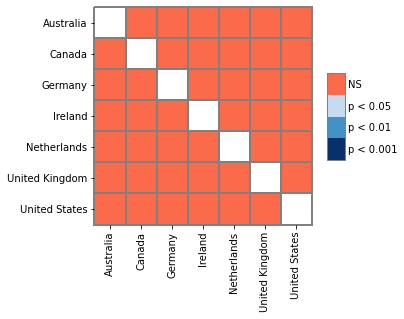

In [71]:
import scikit_posthocs as sp

pc = sp.posthoc_dunn(df, val_col='averageMinutesToReadNative', group_col='hostingLocation', p_adjust= 'bonferroni')
# Format: diagonal, non-significant, p<0.001, p<0.01, p<0.05
cmap = ['1', '#fb6a4a',  '#08306b',  '#4292c6', '#c6dbef']
heatmap_args = {'cmap': cmap, 'linewidths': 0.25, 'linecolor': '0.5', 'clip_on': False, 'square': True, 'cbar_ax_bbox': [0.80, 0.35, 0.04, 0.3]}
sp.sign_plot(pc, **heatmap_args)